# Fit the optical spectrum of Type 1 AGN (SDSS J082912.67+500652.3)
* Check [astropy.modelling](https://docs.astropy.org/en/latest/modeling/index.html) for more introduction
* SAGAN adopts the frame work of astropy.modelling
* Modified by Guodong and edited on 12/12/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from sfdmap2 import sfdmap
from PyAstronomy import pyasl
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.time import Time

from astropy.modeling import models, fitting
import sys
sys.path.append('../../SAGAN-Modified/')
import sagan


import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

/Users/liguodong/Macbook-liguodong/KIAA/IRAS_SDSS/Sample/v2/Test/Spec_fit/SAGAN-Modified/example/../../SAGAN-Modified/sagan/stellar_continuum.py:43: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


# Find the Spectrum from the SDSS archive
* Check [astroquery.sdss](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html) for more introduction

In [2]:
def SDSS_data(hdu):
    data    = hdu
    lam     = np.asarray(10 ** data[1].data['loglam'], dtype=np.float64)
    
    flux    = np.asarray(data[1].data['flux'], dtype=np.float64) 
    err     = np.asarray(1 / np.sqrt(data[1].data['ivar']), dtype=np.float64)
    z       = data[2].data['z'][0]  # Redshift
    
    ra      = data[0].header['plug_ra']  # RA
    dec     = data[0].header['plug_dec']  # DEC
    ind_gooderror = np.where((err > 0) & np.isfinite(err) & (flux != 0) & np.isfinite(flux), True, False)
    err     = err[ind_gooderror]
    flux    = flux[ind_gooderror]
    lam     = lam[ind_gooderror]
    return lam, flux, err, z, ra, dec

def DeRedden(lam, flux, err, ra, dec, dustmap_path):
    m           = sfdmap.SFDMap(dustmap_path)
    zero_flux   = np.where(flux == 0, True, False)
    flux[zero_flux]         = 1e-10
    flux_unred  = pyasl.unred(lam, flux, m.ebv(ra, dec))
    err_unred   = err * flux_unred / flux
    flux_unred[zero_flux]   = 0
    return flux_unred, err_unred

def RestFrame(lam, flux, err, z):
    lam_res = lam / (1 + z)
    flux_res= flux * (1 + z)
    err_res = err * (1 + z)
    ins = (err_res>0)&(flux_res>err_res)
    return lam_res[ins], flux_res[ins], err_res[ins]

/Users/liguodong/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Text(0.5, 1.0, 'SDSS J082912.67+500652.3')

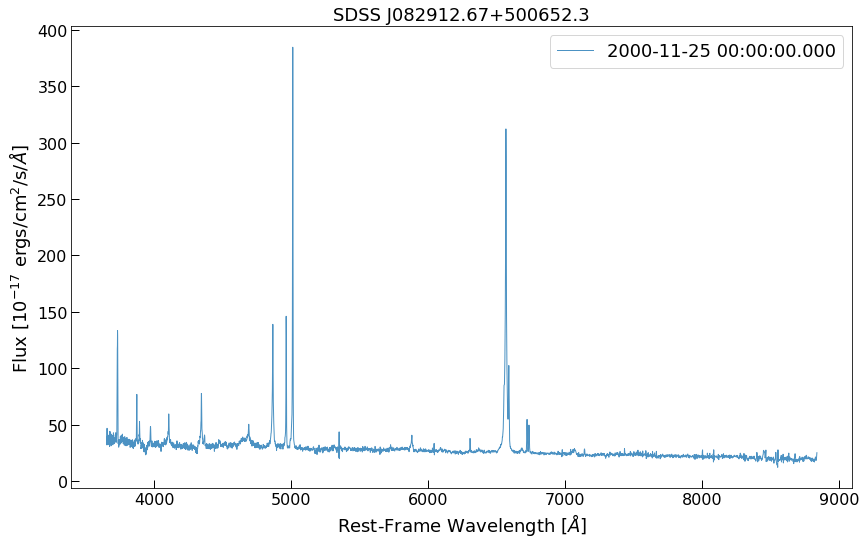

In [3]:
#Find the spectrum
pos = coords.SkyCoord('08h29m12.67s +50d06m52.3s', frame='icrs')
xid = SDSS.query_region(pos, spectro=True,radius=5*u.arcsec)
sp = SDSS.get_spectra(matches=xid)

fig, ax = plt.subplots(figsize=(14.,8.5))
for i in np.arange(xid['ra'].size):
    hdr=sp[i][0].header
    t   =Time(float(hdr['MJD']),format='mjd')
    t.format='iso'
    ax.plot((10.**sp[i][1].data['loglam'])/(1+sp[i][2].data['z'][0]),sp[i][1].data['flux'],label=t.value,linewidth=1,alpha=0.8)
ax.set_ylabel(r'Flux [10$^{-17}$ ergs/cm$^2$/s/$\AA$]',fontsize=18)
ax.set_xlabel('Rest-Frame Wavelength [$\AA$]',fontsize=18)
ax.legend(loc='upper right',fontsize=18)
ax.set_title('SDSS J082912.67+500652.3',fontsize=18)

### Read data and correct the Milky Way extinction
* Check [here](https://github.com/kbarbary/sfddata) for dust map
* Check [here](https://github.com/sczesla/PyAstronomy/tree/master) for the dust correction

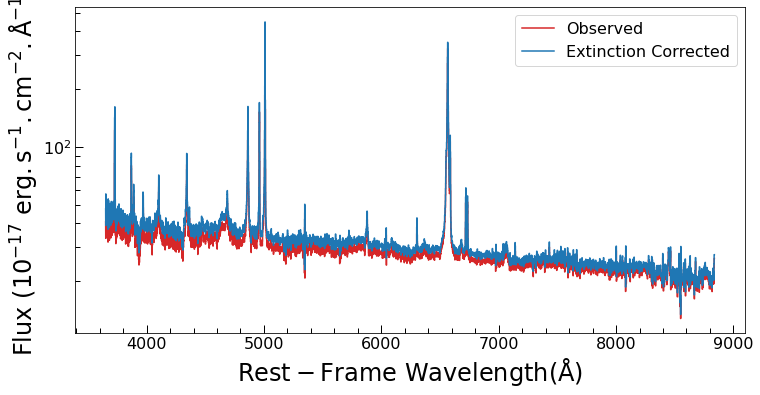

In [4]:
#Select the first spectrum and make the dust correction from the Milky Way (Schlegel, Finkbeiner and Davis 1998)
hdu = sp[0]
dustmap_path    = '../sagan/data/sfddata/'
    
lam_obs, flux_obs, err_obs, z, ra, dec           = SDSS_data(hdu)
flux_unred, err_unred                            = DeRedden(lam_obs, flux_obs, err_obs, ra, dec, dustmap_path)
lam_res, flux_res, err_res                       = RestFrame(lam_obs, flux_obs, err_obs, z)
lam_res_unred, flux_res_unred, err_res_unred     = RestFrame(lam_obs, flux_unred, err_unred, z)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(lam_res, flux_res, label='Observed', c='C3')
ax.step(lam_res_unred, flux_res_unred, label='Extinction Corrected', c='C0')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.legend(fontsize=16)
ax.minorticks_on()
plt.show()

### Cut the useful data
* First move to the rest frame
* Cut the wavelength range following Kuhn et al. (2024)

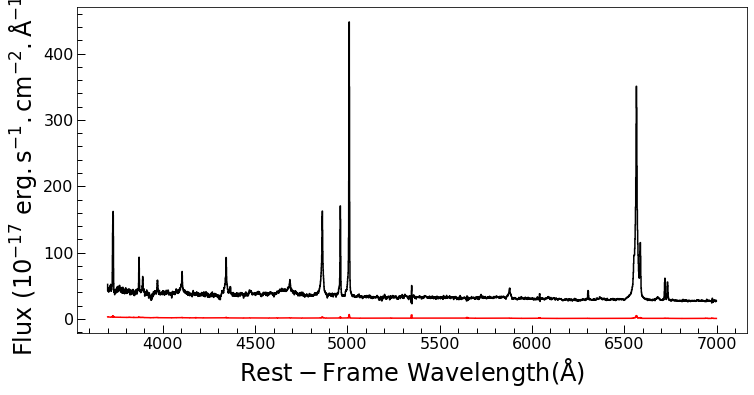

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 3700, 7000
fltr = (lam_res_unred > wmin) & (lam_res_unred < wmax)
wave_use = lam_res_unred[fltr]
flux_use = flux_res_unred[fltr]
ferr = err_res_unred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.step(wave_use, ferr, color='r')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
#ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.minorticks_on()
plt.show()

### Fit spectrum
* Check the emission lines here: http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
* Tie all the narrow lines to [S II] $\lambda\lambda$ 6718,6733 doublet
* Iterate many times until you find a good result
* * The continuum will be fitted using the FeII + PL + Star (A, F, G, K, M) model to a specified spectral window.
* * Fitting [S II] line and using it as narrow line template, fixing the shape of the continuum and optionally fitting its amplitude
* * Fitting other lines, using narrow line template ([S II]) and fixing the shape of the continuum and optionally fitting its amplitude

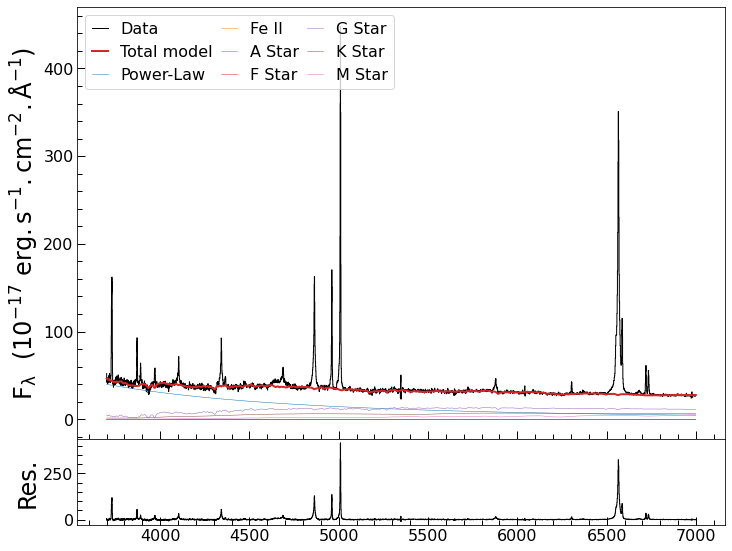

In [6]:
cont_window_lo = [3700, 3740, 4041, 4150, 5550, 6000, 6400]
cont_window_up = [3715, 3800, 4043, 4250, 5850, 6290, 6450]
ins = np.zeros_like(wave_use, dtype=bool)
for i in range(len(cont_window_up)):
    ins |= (wave_use > cont_window_lo[i]) & (wave_use < cont_window_up[i])
cont_x = wave_use[ins]
cont_y = flux_use[ins]
cont_y_e = ferr[ins]
sdss_velscale = 69.03

pl = models.PowerLaw1D(amplitude=0.55, x_0=5500, alpha=1.0, fixed={'x_0': True}, name='Power-Law')
iron = sagan.IronTemplate(amplitude=0.2, stddev=900, z=0, name='Fe II')
iron.z.fixed = True
Star_A = sagan.StarSpectrum(amplitude=1, sigma=500, velscale=sdss_velscale, Star_type='A', name='A Star')
Star_F = sagan.StarSpectrum(amplitude=1, sigma=500, velscale=sdss_velscale, Star_type='F', name='F Star')
Star_G = sagan.StarSpectrum(amplitude=1, sigma=500, velscale=sdss_velscale, Star_type='G', name='G Star')
Star_K = sagan.StarSpectrum(amplitude=1, sigma=500, velscale=sdss_velscale, Star_type='K', name='K Star')
Star_M = sagan.StarSpectrum(amplitude=1, sigma=500, velscale=sdss_velscale, Star_type='M', name='M Star')

m_init = pl + iron + Star_A + Star_F + Star_G + Star_K + Star_M
fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

conti_weights = 1/cont_y_e
weights = 1/ferr
m_fit_cont = fitter(m_init, cont_x, cont_y, weights=conti_weights, maxiter=10000)  

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_cont, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

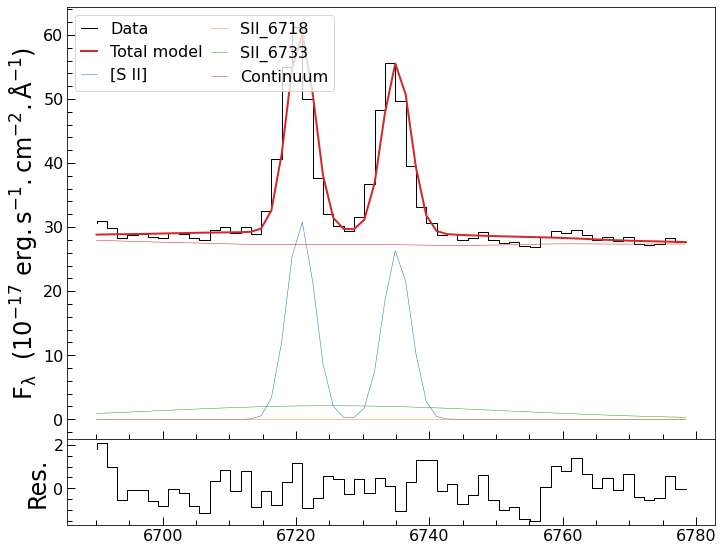

In [7]:
ins = (wave_use>6690)&(wave_use<6780)

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
bounds = {'sigma_c': (30, 4000), 'dv_c':(-2000, 2000)}
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=1,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
bounds = {'sigma': (1200, 4000)}
b_s2_1 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['SII_6718'], name=f'SII_6718', bounds=bounds)
b_s2_2 = sagan.Line_Gaussian(amplitude=0.4, wavec=wave_dict['SII_6733'], name=f'SII_6733', bounds=bounds)

def m_fit_cont_func(x):
    return m_fit_cont(x)
cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum')
cont.amplitude.fixed = True

m_init  = line_s2+b_s2_1+b_s2_2+cont
fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

weights = 1/ferr

m_fit_SII = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights[ins], maxiter=20000, filter_non_finite=True, estimate_jacobian=True)

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_SII, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

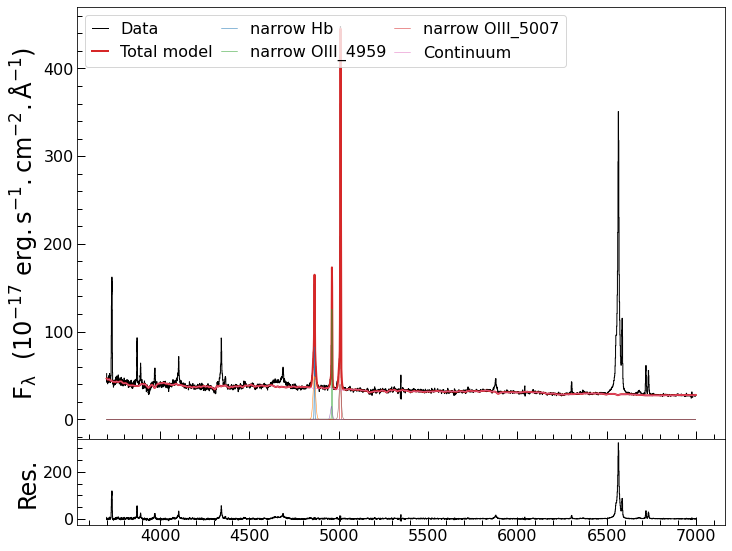

In [8]:
n_hb = sagan.Line_Gaussian(amplitude=3, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
b_hb = sagan.Line_Gaussian(amplitude=3, wavec=wave_dict['Hbeta']) #, name=f'broad Hb'

n_OIII_1 = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['OIII_4959'], name=f'narrow OIII_4959')
n_OIII_2 = sagan.Line_Gaussian(amplitude=1.4, wavec=wave_dict['OIII_5007'], name=f'narrow OIII_5007')

b_OIII_1 = sagan.Line_Gaussian(amplitude=1, wavec=wave_dict['OIII_4959']) #, name=f'broad OIII_4959'
b_OIII_2 = sagan.Line_Gaussian(amplitude=1, wavec=wave_dict['OIII_5007']) #, name=f'broad OIII_5007'


def tie_o3(model):
    return model['narrow OIII_5007'].amplitude / 2.98
n_OIII_1.amplitude.tied = tie_o3


def tie_narrow_sigma(model):
    return m_fit_SII.sigma_c_0.value

def tie_narrow_dv(model):
    return m_fit_SII.dv_c_0.value

for line in [n_hb, n_OIII_1, n_OIII_2]:
    line.sigma.tied = tie_narrow_sigma
    #line.dv.tied = tie_narrow_dv

line_hb = n_hb+b_hb
line_OIII = n_OIII_1+n_OIII_2+b_OIII_1+b_OIII_2
    
m_init = line_hb+ line_OIII + cont

fitter = fitting.LevMarLSQFitter()
ins = ((wave_use>4800)&(wave_use<5100))

weights_lines = 1/ferr[ins]
weights = 1/ferr

#weights_lines = np.ones_like(line_flux[ins])
#weights = np.ones_like(line_flux)

m_fit_Hb = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights_lines, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Hb, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

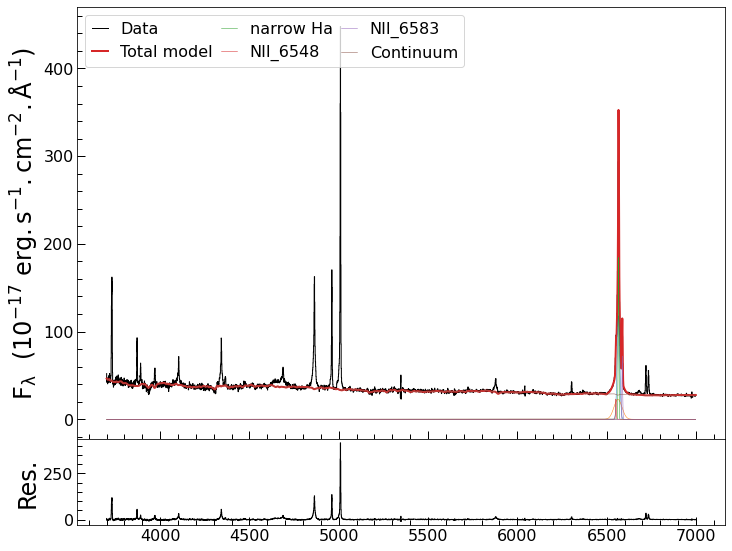

In [9]:
n_ha = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_NII_1 = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['NII_6548'], name=f'NII_6548')
n_NII_2 = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['NII_6583'], name=f'NII_6583')
bounds_Ha = {'sigma': (100, 30000), 'dv':(-1000, 200)}
b_ha_1 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['Halpha'], bounds=bounds_Ha)#name=f'broad Ha', 
b_ha_2 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['Halpha'], bounds=bounds_Ha)#name=f'broad Ha',

def tie_narrow_sigma(model):
    return m_fit_SII.sigma_c_0.value
def tie_narrow_dv(model):
    return m_fit_SII.dv_c_0.value
for line in [n_NII_1, n_NII_2]:
    line.sigma.tied = tie_narrow_sigma
    #line.dv.tied = tie_narrow_dv
for line in [n_ha]:
    line.sigma.tied = tie_narrow_sigma
def tie_n2(model):
    return model['NII_6583'].amplitude / 2.96
n_NII_1.amplitude.tied = tie_n2

line_ha = b_ha_1+b_ha_2+n_ha
line_NII = n_NII_1+n_NII_2
    
m_init = line_ha+line_NII+cont

fitter = fitting.LevMarLSQFitter()
ins = ((wave_use>6400)&(wave_use<6700))

weights_lines = 1/ferr[ins]
weights = 1/ferr

#weights_lines = np.ones_like(line_flux[ins])
#weights = np.ones_like(line_flux)

m_fit_Ha = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights_lines, maxiter=50000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Ha, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

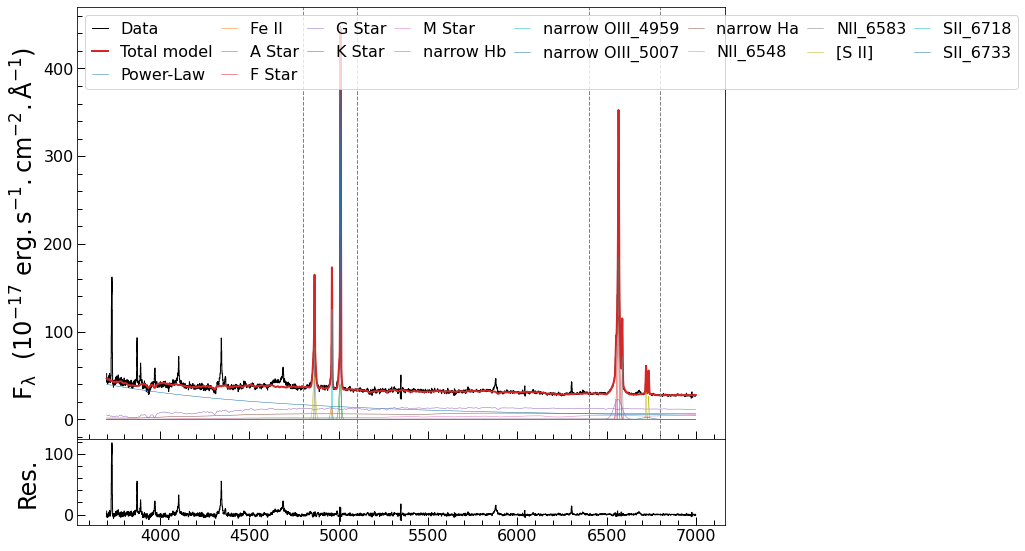

In [10]:
m_fit_cont
m_fit_SII_no_cont = m_fit_SII.left
m_fit_Hb_no_cont = m_fit_Hb.left
m_fit_Ha_no_cont = m_fit_Ha.left
m_fit = m_fit_cont+m_fit_Hb_no_cont+m_fit_Ha_no_cont+m_fit_SII_no_cont
ax, axr = sagan.plot.plot_fit(wave_use, flux_use,m_fit, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.axvline(x=4800, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=5100, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=6400, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=6800, linewidth=1, linestyle='--', color='gray')
plt.show()

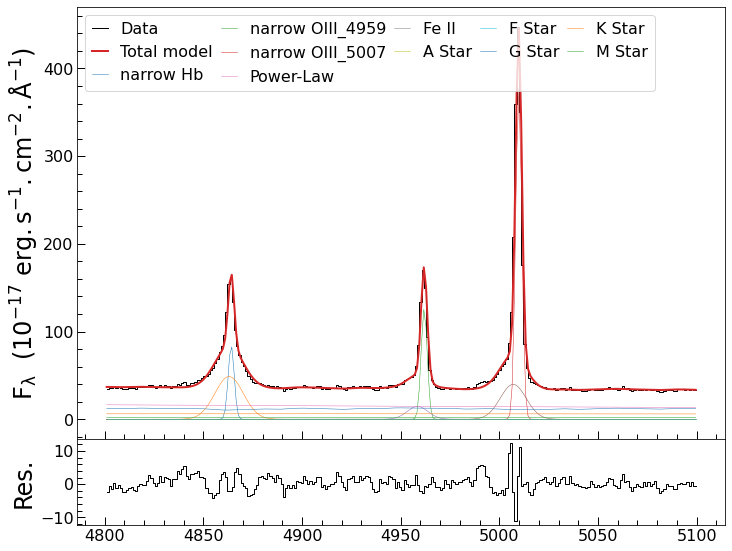

In [11]:
ins = (wave_use>4800)&(wave_use<5100)
ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_Hb.left+m_fit_cont, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

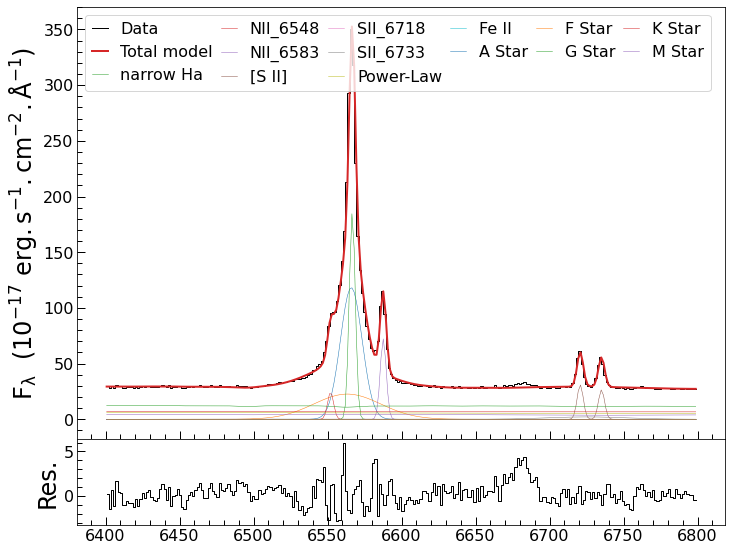

In [12]:
ins = (wave_use>6400)&(wave_use<6800)
ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_Ha.left+m_fit_SII.left+m_fit_cont, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()